<h3>Faz previsão com os dados de 2025 (não vistos pelo modelo) </h3>

In [3]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [3]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, p=1, d=1, q=1, P=0, D=0, Q=0, seasonal_periods=7):
        # These parameters define the ARIMA and seasonal orders
        self.p = p
        self.d = d
        self.q = q
        self.P = P
        self.D = D
        self.Q = Q
        self.seasonal_periods = seasonal_periods

    def fit(self, X, y):
        """
        Fit the SARIMAX model using the training data.
        X: features (independent variables)
        y: target (dependent variable)
        """
        self.model = SARIMAX(endog=y, exog=X, 
                             order=(self.p, self.d, self.q),
                             seasonal_order=(self.P, self.D, self.Q, self.seasonal_periods))
        self.model_fitted = self.model.fit(disp=False)  # Silent fit to avoid clutter
        return self

    def predict(self, X):
        """
        Make predictions using the fitted SARIMAX model.
        X: features (independent variables)
        """
        return self.model_fitted.predict(exog=X)

    def get_params(self, deep=True):
        """
        Return model parameters to use with scikit-learn.
        """
        return {'p': self.p, 'd': self.d, 'q': self.q,
                'P': self.P, 'D': self.D, 'Q': self.Q,
                'seasonal_periods': self.seasonal_periods}

    def set_params(self, **params):
        """
        Set parameters for SARIMAX model.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [4]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [5]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

In [6]:
df = pd.read_csv('df_eng_2.csv',index_col='data_hora',parse_dates=True)
df =df.asfreq('W')

In [7]:
df = df.drop(['Temp. Max. (C)','Temp. Min. (C)', 'Umi. Ins. (%)',
       'Umi. Max. (%)', 'Umi. Min. (%)', 'Pto Orvalho Ins. (C)',
       'Pto Orvalho Max. (C)', 'Pto Orvalho Min. (C)', 'Pressao Ins. (hPa)',
       'Pressao Max. (hPa)', 'Pressao Min. (hPa)', 'Vel. Vento (m/s)',
       'Dir. Vento (m/s)', 'Raj. Vento (m/s)',
       'Chuva (mm)','Mes'],axis=1)

In [8]:
df.head()

,Unnamed: 0,Temp. Ins. (C),Radiacao (KJ/m²),Ano
data_hora,,,,
2023-01-29,0,22.969444,1580.177778,2023
2023-02-05,1,24.509524,1767.392857,2023
2023-02-12,2,25.157143,1762.996429,2023
2023-02-19,3,25.451190,1892.951190,2023
2023-02-26,4,24.008333,1735.534524,2023


In [9]:
# Reordenar as colunas do DataFrame
new_order = ['Temp. Ins. (C)', 'Ano', 'Radiacao (KJ/m²)']  # Substitua pelos nomes das colunas na ordem desejada
df_reordered = df[new_order]

# Verificar o resultado
print(df_reordered.head())


            Temp. Ins. (C)   Ano  Radiacao (KJ/m²)
data_hora                                         
2023-01-29       22.969444  2023       1580.177778
2023-02-05       24.509524  2023       1767.392857
2023-02-12       25.157143  2023       1762.996429
2023-02-19       25.451190  2023       1892.951190
2023-02-26       24.008333  2023       1735.534524


In [10]:
df_reordered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2023-01-29 to 2024-12-29
Freq: W-SUN
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temp. Ins. (C)    101 non-null    float64
 1   Ano               101 non-null    int64  
 2   Radiacao (KJ/m²)  101 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


In [11]:
df_reordered.columns = ['exog1','exog2','target']

In [12]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(df_reordered['target'])
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.


<h3>SARIMAX</h3>

In [13]:
# Number of rows to reserve for testing
test_weeks = 30  # You might want to call this test_rows if it represents rows, not weeks
#df_without_test = df.iloc[:-test_weeks]
# Split the data
train, test = df_reordered.iloc[:-test_weeks], df_reordered.iloc[-test_weeks:]

# Check the length of the train and test sets
print(f"Training data size: {len(train)}")
print(f"Test data size: {len(test)}")


Training data size: 71
Test data size: 30


In [14]:
# Split the Regressor Data into training and test
test_weeks = 30 # Number of days to reserve for testing
exog_train, exog_test = df_reordered.iloc[:-test_weeks,0:2], df_reordered.iloc[-test_weeks:,0:2]
# Check the length of the train and test sets
print(f"Training exog size: {len(exog_train)}")
print(f"Test exog size: {len(exog_test)}")


Training exog size: 71
Test exog size: 30


In [15]:
exog_test

,exog1,exog2
data_hora,,
2024-06-09,21.845833,2024
2024-06-16,22.260714,2024
2024-06-23,22.195238,2024
2024-06-30,23.281548,2024
2024-07-07,22.484524,2024
2024-07-14,23.455357,2024
2024-07-21,21.525000,2024
2024-07-28,22.029762,2024
2024-08-04,22.526190,2024


In [16]:
model_sarimax = auto_arima(train['target'],
                           m = 52,
                           X = exog_train)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -458.710
Date:                Wed, 26 Feb 2025   AIC                            925.419
Time:                        15:33:53   BIC                            934.470
Sample:                    01-29-2023   HQIC                           929.019
                         - 06-02-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog1         89.3046     11.246      7.941      0.000      67.262     111.347
exog2         -0.2942      0.138     -2.130      0.033      -0.565      -0.023
ma.L1          0.3642      0.122      2.993      0.003       0.126       0.603
sigma2      2.443e+04   5201.745      4.696      0.000    1.42e+04    3.46e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.95   Prob(JB):                         0.46
Heteroskedasticity (H):               0.89   Skew:                            -0.22
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#PREVISÕES COM DADOS DE TESTE
predictions_sarimax = model_sarimax.predict(n_periods = len(test),
                                            X = exog_test)
predictions_sarimax

2024-06-09    1378.774875
2024-06-16    1392.608779
2024-06-23    1386.761455
2024-06-30    1483.773875
2024-07-07    1412.595995
2024-07-14    1499.295863
2024-07-21    1326.906121
2024-07-28    1371.983673
2024-08-04    1416.317020
2024-08-11    1437.686331
2024-08-18    1604.281906
2024-08-25    1738.876673
2024-09-01    1573.769507
2024-09-08    1853.271592
2024-09-15    1776.193231
2024-09-22    1917.060581
2024-09-29    2005.727275
2024-10-06    2074.406753
2024-10-13    1792.034163
2024-10-20    1419.187524
2024-10-27    1574.938972
2024-11-03    1457.248288
2024-11-10    1427.373778
2024-11-17    1371.239468
2024-11-24    1588.972549
2024-12-01    1593.650408
2024-12-08    1699.912232
2024-12-15    1625.863848
2024-12-22    1528.479325
2024-12-29    1471.813440
Freq: W-SUN, dtype: float64

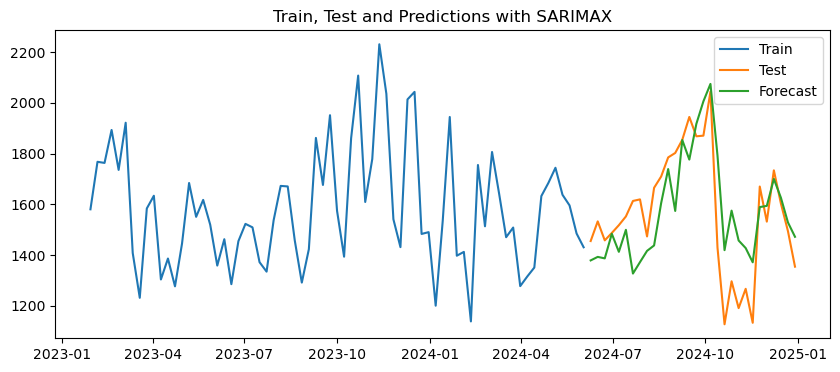

The MAE is 132.64
The RMSE is 166.59
The MAPE is 9.13 %


In [18]:
model_assessment(train['target'], test['target'], predictions_sarimax, "SARIMAX")

<h3>Cross Validation</h3>

<h4>Best parameters: ({'D': 0, 'P': 0, 'Q': 0, 'd': 1, 'p': 1, 'q': 1}, 233.4148052748329)</h4>

In [19]:
model_cv = ARIMA(order = (0, 0, 1), seasonal_order = (0, 0, 0, 52))

In [20]:
cv = model_selection.RollingForecastCV(h = 15, # forecast horizon
                                       step = 4, # moves the validation window by n time steps each iteration
                                       initial = train.shape[0] - 70) # starting point for the first training set

In [21]:
cv_score = model_selection.cross_val_score(model_cv,
                                           y=train['target'],  # Target variable 'y'
                                           X=exog_train,  # Explanatory variables from columns 1 and 2
                                           scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                           cv=cv,  # Cross-validation strategy
                                           verbose=1,  # Verbosity level
                                           error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                           )

In [22]:
# Calculate Root Mean Squared Error (RMSE) using cross-validated scores.
rmse = np.sqrt(np.average(cv_score))
print(f"The RMSE is {int(rmse)}")

The RMSE is 96362411165


<h3>Parameter tuning</h3>

In [23]:
param_grid = {'p': [1,2,3],
              'd': [0,1],
              'q': [1,2,3],
              'P': [1,2],
              'D': [0],
              'Q': [1,2]}
grid = ParameterGrid(param_grid)
len(list(grid))

72

In [24]:
# Initialize an empty list to store RMSE values for each parameter set
rmse_list = []

# Iterate over each set of parameters in the grid
for params in grid:

  # Build an ARIMA model with the current set of parameters
  model = ARIMA(order=(params['p'], params['d'], params['q']),
                seasonal_order=(params['P'], params['D'], params['Q'], 52))

  # Define the Rolling Forecast Cross-Validation strategy
  cv = model_selection.RollingForecastCV(h=15,
                                         step=4,
                                         initial=train.shape[0]-70)

  # Perform cross-validation scoring with the ARIMA model
  cv_score = model_selection.cross_val_score(model,
                                             y=train['target'],  # Target variable 'y'
                                             X=exog_train,  # Explanatory variables from columns 1 and 2
                                             scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                             cv=cv,  # Cross-validation strategy
                                             verbose=1,  # Verbosity level
                                             error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                             )

  # Calculate RMSE and store the error
  rmse = np.sqrt(np.average(cv_score))
  rmse_list.append(rmse)

In [26]:
# Initialize an empty list to store RMSE values for each parameter set
rmse_list = []

# Iterate over each set of parameters in the grid
for params in grid:

    # Build an ARIMA model with the current set of parameters
    model = ARIMA(order=(params['p'], params['d'], params['q']),
                  seasonal_order=(params['P'], params['D'], params['Q'], 52))

    # Define the Rolling Forecast Cross-Validation strategy
    cv = model_selection.RollingForecastCV(h=10,
                                           step=4,
                                           initial=train.shape[0]-70)

    # Perform cross-validation scoring with the ARIMA model
    try:
        cv_score = model_selection.cross_val_score(model,
                                                   y=train['target'],  # Target variable 'y'
                                                   X=exog_train,  # Explanatory variables from columns 1 and 2
                                                   scoring='mean_squared_error',  # Evaluate using MSE
                                                   cv=cv,  # Cross-validation strategy
                                                   verbose=1,  # Verbosity level
                                                   error_score=np.nan  # Use NaN to handle errors gracefully
                                                   )
        
        # Calculate RMSE and store the error
        rmse = np.sqrt(np.nanmean(cv_score))  # Ensure NaN values are handled
        rmse_list.append(rmse)
        
    except Exception as e:
        print(f"Error during fitting with params {params}: {e}")
        rmse_list.append(np.nan)  # In case of error, append NaN to the RMSE list

# Print the RMSE results for each parameter set
print(rmse_list)


[164.80476650658727, 168.93157936502269, 169.03466599490963, 175.216155948566, 174.53349018258032, 158.91895091771468, 177.84910740510327, 176.32114683559823, 170.22401992672383, 152.62972510735577, 149.9875257135334, 151.58378861942853, 136.3297617490089, 145.5214043955934, 189.19483290663894, 143.6952466793351, 167.40626319145298, 171.9861149027215, 164.56955023582864, 166.66898469397844, 167.436986983265, 176.5881116619919, 174.5996967897106, 158.5666427498304, 178.26677588138145, 175.99559765574904, 172.65058393937514, 139.38976675277138, 151.1666319318527, 200.9884153178821, 132.88158162911478, 146.65135396756614, 177.1795065193814, 135.04933438476536, 176.5745521855392, 188.4434387455676, 165.36217187624112, 169.92242233840668, 167.56355144927272, 177.53566761255004, 174.81569713443974, 157.98367010137483, 178.6413585965691, 176.37481838663098, 170.77178600564486, 133.33191607098038, 127.84177809419957, 198.1125486252695, 132.21672547807955, 149.1501669461339, 173.4729607580954, 

In [27]:
# Teste o ajuste do modelo diretamente com um conjunto de dados pequeno
params = {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}  # Escolha um conjunto de parâmetros pequeno
model = ARIMA(order=(params['p'], params['d'], params['q']),
              seasonal_order=(params['P'], params['D'], params['Q'], 52))

# Ajuste o modelo diretamente com o conjunto de dados
try:
    model_fit = model.fit(train['target'])
    print(model_fit.summary())
except Exception as e:
    print(f"Erro ao ajustar o modelo: {e}")


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   71
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                -479.660
Date:                            Wed, 26 Feb 2025   AIC                            971.321
Time:                                    16:28:14   BIC                            984.897
Sample:                                01-29-2023   HQIC                           976.720
                                     - 06-02-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1148.7706   1723.360      0.667      0.505   -2228.953    4526.494
ar.L1          0.1070      0.259   

In [28]:
# Create a DataFrame to store the tuning results with parameters and corresponding RMSE values
tuning_results = pd.DataFrame(grid)

# Add the RMSE values calculated during parameter tuning to the DataFrame
tuning_results['rmse'] = rmse_list

tuning_results

,D,P,Q,d,p,q,rmse
0,0,1,1,0,1,1,164.804767
1,0,1,1,0,1,2,168.931579
2,0,1,1,0,1,3,169.034666
3,0,1,1,0,2,1,175.216156
4,0,1,1,0,2,2,174.533490
...,...,...,...,...,...,...,...
67,0,2,2,1,2,2,141.772447
68,0,2,2,1,2,3,178.654659
69,0,2,2,1,3,1,144.080754
70,0,2,2,1,3,2,172.425996


In [110]:
# Save the best parameters
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()].transpose()
best_params

,13
D,0.000000
P,1.000000
Q,1.000000
d,1.000000
p,2.000000
q,2.000000
rmse,0.088758


<h3>Predicting the future - Using 2025 dataset</h3>

In [194]:
# target variable - daily revenue
y = train['target']
# exogenous variables
X = exog_train

<h4>Melhores parâmetros: (0,2,1)x(1,2,1)</h4>

In [195]:
# Tuned Sarimax Model with the best parameters
tuned_model = ARIMA(order = (1, 2, 2),
                    seasonal_order = (0, 1, 1, 52))
# fit the model, add exogenous variables as X
tuned_model_fit = tuned_model.fit(y,X=X)

In [196]:
# Salvar o modelo ajustado em um arquivo .pkl
import pickle
with open('modelo_arima.pkl', 'wb') as file:
    pickle.dump(tuned_model, file)

In [214]:
# Supondo que você tenha novos dados em um arquivo CSV ou em formato pandas DataFrame
novos_dados = pd.read_csv('df_eng_2.csv', index_col='data_hora',parse_dates=True)

In [215]:
novos_dados.columns

Index(['Unnamed: 0', 'Temp. Ins. (C)', 'Temp. Max. (C)', 'Temp. Min. (C)',
       'Umi. Ins. (%)', 'Umi. Max. (%)', 'Umi. Min. (%)',
       'Pto Orvalho Ins. (C)', 'Pto Orvalho Max. (C)', 'Pto Orvalho Min. (C)',
       'Pressao Ins. (hPa)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
       'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)',
       'Radiacao (KJ/m²)', 'Chuva (mm)', 'Mes', 'Ano'],
      dtype='object')

In [216]:
novos_dados = novos_dados.drop([ 'Temp. Max. (C)', 'Temp. Min. (C)',
       'Umi. Ins. (%)', 'Umi. Max. (%)', 'Umi. Min. (%)',
       'Pto Orvalho Ins. (C)', 'Pto Orvalho Max. (C)', 'Pto Orvalho Min. (C)',
       'Pressao Ins. (hPa)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
       'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)',
        'Chuva (mm)', 'Mes'],axis=1)

In [217]:
# Reordenar as colunas do DataFrame
new_order_2 = ['Temp. Ins. (C)', 'Ano', 'Radiacao (KJ/m²)']  # Substitua pelos nomes das colunas na ordem desejada
novos_dados_2 = novos_dados[new_order_2]

# Verificar o resultado
print(novos_dados_2.head())


            Temp. Ins. (C)   Ano  Radiacao (KJ/m²)
data_hora                                         
2023-01-29       22.969444  2023       1580.177778
2023-02-05       24.509524  2023       1767.392857
2023-02-12       25.157143  2023       1762.996429
2023-02-19       25.451190  2023       1892.951190
2023-02-26       24.008333  2023       1735.534524


In [218]:
novos_dados_2.columns = ['exog1','exog2','target']

In [219]:
exogenas_2025 = novos_dados_2[['exog1', 'exog2']]

In [220]:
novos_dados_2

,exog1,exog2,target
data_hora,,,
2023-01-29,22.969444,2023,1580.177778
2023-02-05,24.509524,2023,1767.392857
2023-02-12,25.157143,2023,1762.996429
2023-02-19,25.451190,2023,1892.951190
2023-02-26,24.008333,2023,1735.534524
...,...,...,...
2024-12-01,24.511905,2024,1531.675000
2024-12-08,25.701786,2024,1733.853571
2024-12-15,24.872619,2024,1602.988095


In [221]:
X_future = novos_dados_2.iloc[:, 0:2]

In [230]:
X_future_2 = X_future.tail(30)

In [231]:
X_future_2.shape

(30, 2)

In [232]:
predictions = tuned_model_fit.predict(n_periods =len(X_future_2),
                                  X = X_future_2)

In [233]:
predictions

2024-06-09    1623.690111
2024-06-16    1413.042832
2024-06-23    1823.276161
2024-06-30    1965.276496
2024-07-07    1883.658089
2024-07-14    1633.357499
2024-07-21    1573.394011
2024-07-28    1777.892716
2024-08-04    1880.661879
2024-08-11    1818.748966
2024-08-18    1947.118597
2024-08-25    1722.782976
2024-09-01    1801.276563
2024-09-08    2451.586581
2024-09-15    2188.539515
2024-09-22    2341.488122
2024-09-29    2175.830412
2024-10-06    2293.654107
2024-10-13    2259.158926
2024-10-20    2071.077433
2024-10-27    1921.244690
2024-11-03    2013.172360
2024-11-10    2186.734350
2024-11-17    1833.540635
2024-11-24    2035.758892
2024-12-01    1959.686980
2024-12-08    2464.482936
2024-12-15    2364.307983
2024-12-22    1989.747982
2024-12-29    1826.758892
Freq: W-SUN, dtype: float64

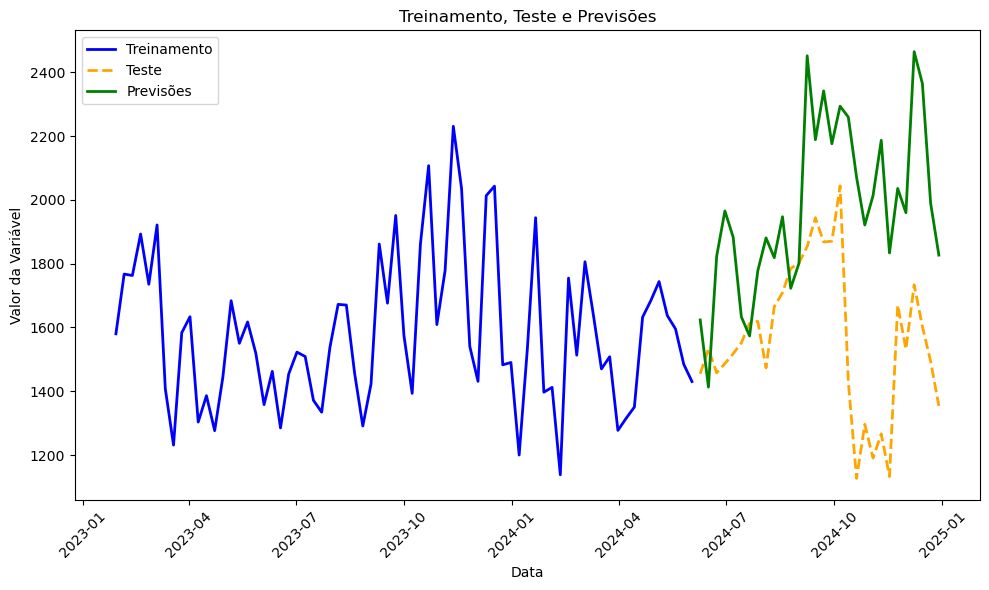

In [237]:
# Criando o gráfico
plt.figure(figsize=(10, 6))

# Plotando os dados de treino
plt.plot(train.index,y, label='Treinamento', color='blue', linewidth=2)

# Plotando os dados de teste
plt.plot(test.index, test['target'], label='Teste', color='orange', linestyle='--', linewidth=2)

# Plotando as previsões
plt.plot(predictions.index, predictions, label='Previsões', color='green', linewidth=2)

# Adicionando rótulos e título
plt.title('Treinamento, Teste e Previsões')
plt.xlabel('Data')
plt.ylabel('Valor da Variável')
plt.legend()

# Exibindo o gráfico
plt.xticks(rotation=45)
#plt.grid(True)
plt.tight_layout()
plt.show()


In [234]:
mae = mean_absolute_error(test['target'], predictions)
rmse = mean_squared_error(test['target'], predictions, squared = False)
mape = mean_absolute_percentage_error(test['target'], predictions)
print(f"The MAE is {mae:.2f}")
print(f"The RMSE is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f} %")

The MAE is 420.20
The RMSE is 500.09
The MAPE is 29.08 %


<h3>Prevendo o futuro</h3>

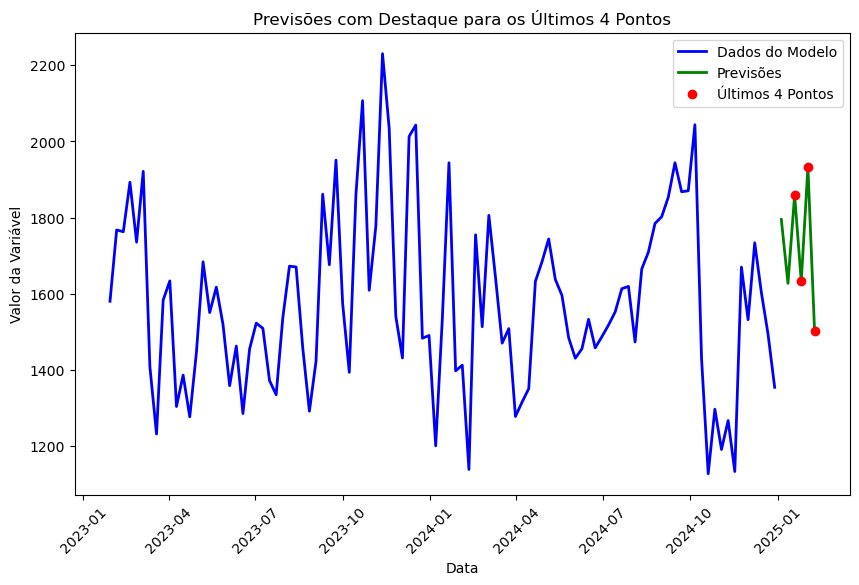

<bound method NDFrame.to_csv of 2025-01-05    1795.126584
2025-01-12    1627.246559
2025-01-19    1859.207654
2025-01-26    1632.756847
2025-02-02    1932.425011
2025-02-09    1502.989074
Freq: W-SUN, dtype: float64>

In [238]:
# target variable - daily revenue
y1 = df_reordered['target']
# exogenous variables
X1 = df_reordered[['exog1','exog2']]

# Tuned Sarimax Model with the best parameters
tuned_model = ARIMA(order = (1, 2, 2),
                    seasonal_order = (0, 1, 1, 52))
# fit the model, add exogenous variables as X
tuned_model_fit = tuned_model.fit(y1,X=X1)

# Salvar o modelo ajustado em um arquivo .pkl
import pickle
with open('modelo_arima.pkl', 'wb') as file:
    pickle.dump(tuned_model, file)

novos_dados_2025 = pd.read_csv('exogenas.csv', index_col='Data', parse_dates=True)

# Renomeando as colunas, caso necessário, para se alinhar com as exógenas
novos_dados_2025.columns = ['exog1', 'exog2']  # Substitua conforme as colunas corretas

# Pegando as variáveis exógenas para 2025
exogenas_2025 = novos_dados_2025[['exog1', 'exog2']]
novos_dados.asfreq('W')
X_future_2 = exogenas_2025.iloc[:, 0:2]


predictions = tuned_model.predict(n_periods = len(X_future_2),
                                  X = X_future_2)

import matplotlib.pyplot as plt

# Criando o gráfico
plt.figure(figsize=(10, 6))

# Plotando os dados do modelo (usando a coluna alvo ou série temporal original)
plt.plot(df_reordered.index, df_reordered['target'], label='Dados do Modelo', color='blue', linewidth=2)

# Plotando as previsões
plt.plot(predictions.index, predictions, label='Previsões', color='green', linewidth=2)

# Destacando os últimos 4 pontos das previsões
ultimos_4_pontos = predictions.tail(4)
plt.scatter(ultimos_4_pontos.index, ultimos_4_pontos, color='red', zorder=5, label='Últimos 4 Pontos')

# Adicionando rótulos e título
plt.title('Previsões com Destaque para os Últimos 4 Pontos')
plt.xlabel('Data')
plt.ylabel('Valor da Variável')
plt.legend()

# Exibindo o gráfico
plt.xticks(rotation=45)
plt.show()

In [239]:
predictions.to_csv('previsoes_radiacao.csv',index=True)

<h3>Comparação entre dados futuros previstos e dados reais </h3>

In [1]:
import pandas as pd

In [2]:
#Dados Reais
dados_reais = pd.read_csv('jan_2025_xg.csv',index_col='data_hora')

In [3]:
dados_reais['Radiacao (KJ/m²)'].head()

data_hora
2025-01-05    1450.613095
2025-01-12    1394.551190
2025-01-19    1472.630952
2025-01-26    2000.155000
Name: Radiacao (KJ/m²), dtype: float64

In [4]:
dados_previstos = pd.read_csv('previsoes_radiacao.csv')

In [5]:
dados_previstos.columns = ['Data','previsoes']

In [6]:
dados_previstos.head()

,Data,previsoes
0,2025-01-05,1795.126584
1,2025-01-12,1627.246559
2,2025-01-19,1859.207654
3,2025-01-26,1632.756847
4,2025-02-02,1932.425011


In [14]:
dados_previstos_2 = dados_previstos.head(4)

In [15]:
dados_previstos_2 

,Data,previsoes
0,2025-01-05,1795.126584
1,2025-01-12,1627.246559
2,2025-01-19,1859.207654
3,2025-01-26,1632.756847


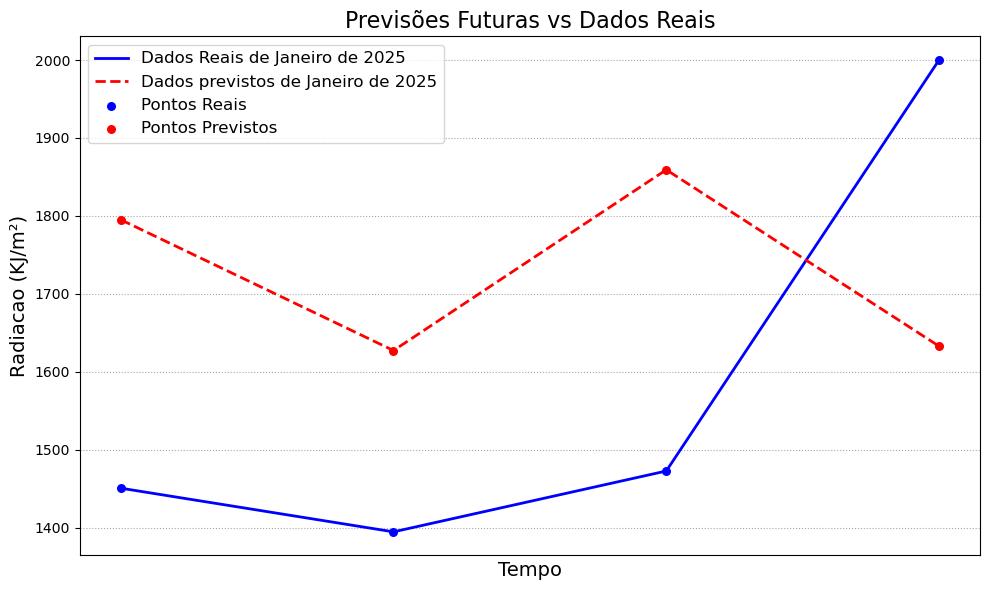

In [16]:
import matplotlib.pyplot as plt

# Aumentando o tamanho da figura para melhor visualização
plt.figure(figsize=(10, 6))

# Plotando os dados reais e previstos
plt.plot(dados_reais['Radiacao (KJ/m²)'], label='Dados Reais de Janeiro de 2025', color='blue', linewidth=2)
plt.plot(dados_previstos_2['previsoes'], label='Dados previstos de Janeiro de 2025', color='red', linestyle='--', linewidth=2)

# Marcando os pontos dos dados reais
plt.scatter(dados_reais.index, dados_reais['Radiacao (KJ/m²)'], color='blue', s=30, label='Pontos Reais', zorder=5)

# Marcando os pontos dos dados previstos
plt.scatter(dados_previstos_2.index, dados_previstos_2['previsoes'], color='red', s=30, label='Pontos Previstos', zorder=5)

# Título e rótulos dos eixos
plt.title('Previsões Futuras vs Dados Reais', fontsize=16)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Radiacao (KJ/m²)', fontsize=14)

# Personalizando os ticks do eixo x
plt.xticks([])  # Remove os rótulos do eixo x

# Adicionando a legenda
plt.legend(fontsize=12)

# Melhorando a grade para uma visualização mais suave
plt.grid(True, linestyle=':', color='gray', alpha=0.7)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta a disposição dos elementos para não sobrepor
plt.show()


In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Obtendo os valores reais e previstos
y_real = dados_reais['Radiacao (KJ/m²)'].values
y_pred = dados_previstos_2['previsoes'].values

# Calculando o RMSE
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# Calculando o MAE
mae = mean_absolute_error(y_real, y_pred)

# Calculando o MAPE
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

# Exibindo as métricas
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')


RMSE: 338.10
MAE: 332.80
MAPE: 21.26%
